# Model Selection


In machine learning applications we seek to fit models that explain our data. From a family of models we try and determine the best model that explains our observations. Techniques of model selection offer principled approaches to determining the 'best' models.

## Example - Linear regression

Consider the regression problem where we observe an input variable $x$ and wish  predict a target variable $y$. The data are generated below

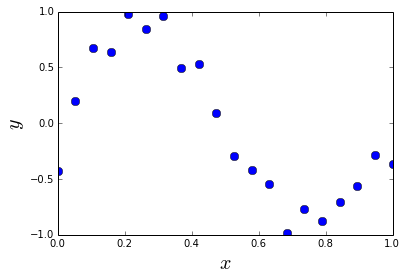

In [2]:
import numpy as np
import matplotlib.pyplot as plt
noise_std=.2 # Noise standard deviation
num_points=20 # Number of data points
X=np.linspace(0,1,num_points) #input variables
Y=np.sin(2*np.pi*X)+noise_std*np.random.randn(len(X)) # target variables

#Plot the points
%matplotlib inline
plt.plot(X,Y,'o',markersize=8)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20)

Suppose we assume that we can use a polynomial to model the relationship between $x$ and $y$
\begin{eqnarray*}
y&=&w_0+w_1x+w_2x^2+\ldots+w_Px^P\\
&=&\sum_{i=0}^Pw_ix^i
\end{eqnarray*}

The model has a set of parameters $\mathbf{w}=[w_0,\ldots,w_P]^T$ and we can write 
\begin{equation*}
y=f(x,\mathbf{w})
\end{equation*}
Given a polynomial order $P$, we learn the parameters $\mathbf{w}^\ast$ that best explain the training data.


By finding the $\mathbf{w}^\ast$ that minimizes the sum of square error
\begin{equation*}
E(\mathbf{w})=\frac{1}{2}\sum_{n=1}^N(f(x_n,\mathbf{w})-y_n)^2
\end{equation*}
we obtain the polynomial fit of the data $f(x,\mathbf{w}^\ast)$


The numpy function $polyfit$ performs this minimization and returns the coefficients. The function $poly1d$ creates a polynomial object. (Use help to find out what these functions do)

In [3]:
np.polyfit?

In [4]:
np.poly1d?

### Fiting the model

We set the polynomial order and fit the polynomial via least squares.


In [5]:
P=3
polynomial=np.poly1d(np.polyfit(X, Y, P))

To plot the polynomial we create a grid and evaluate the polynomial at these points.


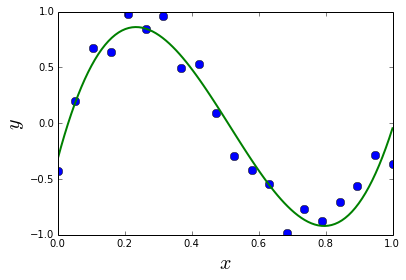

In [6]:
x_plot=np.linspace(0,1,100)

%matplotlib inline
plt.plot(X,Y,'o',markersize=8)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20)
plt.plot(x_plot,polynomial(x_plot),linewidth=2)

Play around with the model order and see what happens as you increase the order. What is the best value for $P$?

## Model Selection

Determining the ideal $P$ is problem in model selection. This parameter governs the complexity of the model.
High values of $P$ are more flexible but harder to fit and may suffer numerical instability especially when data are limited.

To determine a good value of $P$ we can monitor the error on a hold out test set. We divide the data into two, a training set and a test set. Here let us use half the data for training and the other half for testing.

In [7]:
X_train=X[range(0,len(X),2)]
X_test=X[range(1,len(X),2)]
Y_train=Y[range(0,len(Y),2)]
Y_test=Y[range(1,len(Y),2)]

We compute the error on the hold out set for $P=0,1,\ldots,9$, a total of 10 values. We also compute the error on the training set.

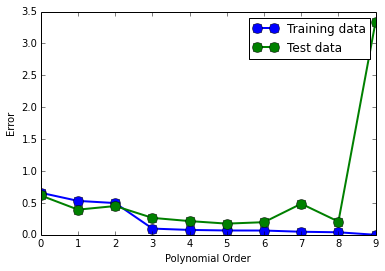

In [8]:
num_order=10
err_test=np.zeros(num_order)
err_train=np.zeros(num_order)
for order in range(num_order):
    polynomial=np.poly1d(np.polyfit(X_train, Y_train, order))
    err_test[order]=np.sqrt(sum((polynomial(X_test)-Y_test)**2)/len(X_test))
    err_train[order]=np.sqrt(sum((polynomial(X_train)-Y_train)**2)/len(X_train))
    
%matplotlib inline    
plt.plot(range(num_order),err_train,'-o',linewidth=2,markersize=10)
plt.plot(range(num_order),err_test,'-o',linewidth=2,markersize=10)
plt.legend(['Training data','Test data'])
plt.xlabel('Polynomial Order')
plt.ylabel('Error')
    


## K-fold Cross-validation

An alternative approach is to divide the data into $K$ (almost) equal sized parts and use $K-1$ parts to fit the model and test the model on the remaining part. We first dived the data using the scikit-learn package KFold.


In [9]:
from sklearn.cross_validation import KFold
import scipy.stats as ss #a package to compute statistics

#Lets generate more data
num_points=200 # Number of data points
X=np.linspace(0,1,num_points) #input variables
Y=np.sin(2*np.pi*X)+noise_std*np.random.randn(len(X)) # target variables

num_order=10
num_folds=5
err_test=np.zeros((num_folds,num_order))
kf = KFold(len(X), n_folds=num_folds)


The variable $kf$ now contains indices indicating which data points correspond to the training and test sets. 

In [10]:
i=0
for train_index, test_index in kf:
    X_train=X[train_index]
    X_test=X[test_index]
    Y_train=Y[train_index]
    Y_test=Y[test_index]
    for order in range(num_order):
        polynomial=np.poly1d(np.polyfit(X_train, Y_train, order))
        err_test[i,order]=np.sqrt(sum((polynomial(X_test)-Y_test)**2)/len(X_test))
        
    i+=1

For each polynomial order we have error rates for each of the K folds. We can compute the $95\%$ confidence interval of the error and estimate model uncertainty.

(0, 10)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


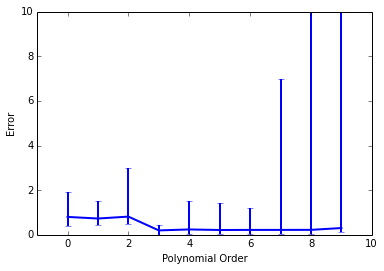

In [11]:
ss.mstats.mquantiles(err_test)
quantiles=ss.mstats.mquantiles(err_test,prob=[0.025, 0.5, 0.975],axis=0)

%matplotlib inline  
plt.errorbar(range(num_order), quantiles[1,:], yerr=[quantiles[0,:],quantiles[2,:]],elinewidth=2,linewidth=2)
plt.xlabel('Polynomial Order')
plt.ylabel('Error')
plt.xlim([-1,10])
plt.ylim([0,10])

## Bayesian Polynomial Regression

We have a data set $D=\{x_i,y_i\}_{i=1}^N$ where $x_i$ are the input variables and $y_i$ are the target variable.
We model the target variables as
\begin{equation}
y_i=f(x_i,\mathbf{w})+\epsilon
\end{equation}
Where $\epsilon$ is zero mean Gaussian noise with variance $\sigma_\epsilon^2$
and $\mathbf{w}$ is a vector of the polynomial coefficients.

The probability of the data $D$ given the parameters for a given model $\mathcal{M}_i$ is
\begin{equation}
p(D|\mathbf{w},\beta,\mathcal{M}_i)=\Big(\frac{\beta}{2\pi}\Big)^{N/2}\exp\Big(-\frac{\beta}{2}\sum_{i=1}^N(f(x_i,\mathbf{w})-y_i)^2\Big)
\end{equation}
where $\beta=\frac{1}{\sigma_\epsilon^2}$ is the noise precision

### The Prior

For a Bayesian treatment of the regression problem, we set a prior over the parameters $\mathbf{w}$. This prior governs the types of interpolants we will obtain.
If the magnitudes of the polynomial coefficients are restricted to small values, the model is inflexible and results in flat interpolants
If the coefficients are allowed to be too large, then the model can be too flexible and oscillate wildly to pass all data points.

We select the following prior
\begin{equation}
p(\mathbf{w}|\alpha,\mathcal{M}_i)=\Big(\frac{\alpha}{2\pi}\Big)^{(P+1)/2}\exp\Big(-\frac{\alpha}{2}\mathbf{w}^T\mathbf{w}\Big)
\end{equation}
where $\alpha$ is the precision of the coefficients. $P$ is the polynomial order.
 When $\alpha$ is small, coefficients can take large values
 When $\alpha$ is large, coefficients are assumed to take small values.
 
 
 ### The Posterior
 
 The posterior distribution of $\mathbf{w}$ is 
\begin{equation}
p(\mathbf{w}|D,\alpha,\beta,\mathcal{M}_i)=\frac{p(D|\mathbf{w},\beta,\mathcal{M}_i)p(\mathbf{w}|\alpha,\mathcal{M}_i)}{p(D|\alpha,\beta,\mathcal{M}_i)}
\end{equation}
 We can show that this is a Gaussian with 
\begin{eqnarray*}
\mu&=&\beta\Sigma\Phi\mathbf{y}\\
\Sigma&=&[\alpha\mathbf{I}+\beta\Phi^T\Phi]^{-1}
\end{eqnarray*}
Where 
\begin{equation}
\Phi=\begin{bmatrix}
    1 & x_{1} & x_{1}^2 & \dots  & x_{1}^P \\
    1 & x_{2} & x_{2}^2 & \dots  & x_{2}^P \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_{N} & x_{N}^2 & \dots  & x_{N}^P
\end{bmatrix}
\end{equation}

Let us generate some data and see the effect of the prior on the inferred interpolant.

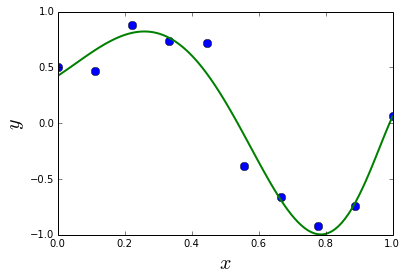

In [14]:
alpha=10e-4
noise_std=.2
num_points=10
X=np.linspace(0,1,num_points)
Y=np.sin(2*np.pi*X)+noise_std*np.random.randn(len(X))

P=9# assume a polynomial order

Phi=np.array([X**i for i in range(P+1)])
Phi=Phi.T
beta=1./(noise_std*noise_std)
A=beta*np.dot(Phi.T,Phi)+alpha*np.eye(P+1)
Cov=np.linalg.inv(A)
mu=beta*np.dot(np.dot(Cov,Phi.T),Y)

#create a polynomial
polynomial=np.poly1d(mu[::-1])
x_plot=np.linspace(0,1,100)

%matplotlib inline
plt.plot(X,Y,'o',markersize=8)
plt.plot(x_plot,polynomial(x_plot),linewidth=2)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$y$',fontsize=20)


Modify the value of $\alpha$ from very large to very small (say 100 to $10^{-4}$) and see the effect on the inferred interpolant. This parameter effectively controls the model complexity.

## The Bayesian Information Criterion

The Bayes factor comparing two models $i$ and $j$ is given by
\begin{equation}
B_{ij}=\frac{p(D|\mathcal{M}_i)}{p(D|\mathcal{M}_j)}
\end{equation}
The log marginal likelihood $p(D|\mathcal{M}_i)$ can be approximated using the Laplace approximation to yeild
\begin{equation}
\log p(D|\mathcal{M}_i)\approx \log p(D|\hat{\theta}_{ML},\mathcal{M}_i)-\frac{d_i}{2}\log(N)
\end{equation}
where $\hat{\theta}_{ML}$, is the maximum likelihood parameter estimate and $d_i$ is the number of free parameters in model $\mathcal{M}_i$

The Bayesian Information Criterion for a model $\mathcal{M}_i$ is defined as
\begin{equation}
BIC_i=-2\log p(D|\hat{\theta}_{ML},\mathcal{M}_i)+d_i\log(N)
\end{equation}

1. The BIC statistic penalizes complex models
2. It includes a penalty term that depends on the number of free parameters in a model
3. We chose the model with the minimum BIC

In [ ]:
#define a function to compute the log likelihood given noise standard deviation
#and ML estimate of the polynomial coefficients
def loglik(x,y,f,sigma):
    return -0.5*np.log(2*np.pi*sigma)-(1./(2*sigma**2))*sum((f(x)-y)**2)


noise_std=.2 # Noise standard deviation
num_points=20 # Number of data points
X=np.linspace(0,1,num_points) #input variables
Y=np.sin(2*np.pi*X)+noise_std*np.random.randn(len(X)) # target variables

num_order=10
BIC=np.zeros(num_order)
for order in range(num_order):
    polynomial=np.poly1d(np.polyfit(X, Y, order))
    BIC[order]= -2*loglik(X,Y,polynomial,noise_std)+(order+1)*np.log(num_points)
    
%matplotlib inline 
plt.plot(range(num_order),BIC,linewidth=2)
plt.xlabel('Polynomial Order')
plt.ylabel('BIC')    
    
    

